
# Seis2Rock - Volve Dataset <br> 
## Petrophysical Inversion on the Fence along well NO 15 9-19 A



This notebook provides an illustration of the petrophysical inversion carried out on the Fence along Well NO 15 9-19 A. It showcases the required data and the Seis2Rock methodology used for the inversion process. In this notebook, we use the well log information of the two wells available. 

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt

import pylops
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.mdd       import *
from pylops.avo.avo                    import *
from pylops.avo.poststack              import *
from pylops.avo.prestack               import *
from pylops.optimization.leastsquares  import *
from scipy.ndimage import gaussian_filter

from seis2rock.seis2rock_functions import *
from seis2rock.seis2rock_utils import *

from pyproximal.proximal import *
from pyproximal.projection import *
from pyproximal.optimization.primaldual import *
from pyproximal.optimization.primal import *

#PnP
import torch
from seis2rock.DnCNN_models import *
from seis2rock.Denoising_scalings import *
from seis2rock.PnP_seismic import *
from pyproximal.optimization.pnp import _Denoise

np.random.seed(5)

## Loading and visualizing data needed

In [2]:
f = np.load('../../data/Volve2dfenceby1degree_NO_15_9-19_A.npz',
            allow_pickle=True) 

# f.files

In [3]:
t_seis = f['t_seis']
t_vrms = f['t_vrms']
t_ainvt = f['t_ainvt']
dt = t_seis[1] - t_seis[0]

seismicd_prestack_fence=f['seismicd_prestack_fence'][:,25:,:] # Just taking positive angles
z_seismic_prestack_fence=f['z_seismic_prestack_fence']
dz = z_seismic_prestack_fence[1] - z_seismic_prestack_fence[0]

vtraces = f['vtraces']
vtraces_z = f['vtraces_z']

seismic_fence = f['seismict_fence']
vrms_fence = f['vrms_fence']
v_fence_depth=f['v_fence_depth']
aiinvt_fence = f['aiinvt_fence']
x_seis = np.arange(seismicd_prestack_fence.shape[0])

horizons_fence = f['horizons_fence'][()]

well_tvdss = f['well_tvdss']
well_twt = f['well_twt']
well_ai = f['well_ai']
well_si = f['well_si']
well_vp = f['well_vp']
well_vs = f['well_vs']
well_rho = f['well_rho']
well_phi = f['well_phi']
well_vsh = f['well_vsh']
well_sw = f['well_sw']

izwellfence=f['izwellfence']
itwellfence=f['itwellfence']
depth_fence=f['depth_fence']
zwell = f['zwell']
zwell_seismic = f['zwell_seismic']

xlsext = f['xlsext']
ilsext = f['ilsext']

well_prestack = f['well_prestack'][:,25:] # Just taking positive angles
well_ai_prestack_sampling = f['well_ai_prestack_sampling']
well_si_prestack_sampling = f['well_si_prestack_sampling']
well_vp_prestack_sampling = f['well_vp_prestack_sampling']
well_vs_prestack_sampling = f['well_vs_prestack_sampling']
well_rho_prestack_sampling = f['well_rho_prestack_sampling']

well_phi_prestack_sampling = f['well_phi_prestack_sampling']
well_vsh_prestack_sampling = f['well_vsh_prestack_sampling']
well_sw_prestack_sampling = f['well_sw_prestack_sampling']

well_vtrace_prestack_sampling= f['well_vtrace_prestack_sampling']


offset = np.load('../../data/doffset_fence_well_NO_15_9-19_BT2.npy') 
wellname = 'NO 15/9-19 A'

Let's load the second well

In [4]:
f2 = np.load('../../data/Volve2dfenceby1degree_NO_15_9-19_BT2.npz', 
            allow_pickle=True) 

In [5]:
well_tvdss_2 = f2['well_tvdss']
well_twt_2 = f2['well_twt']
well_ai_2 = f2['well_ai']
well_si_2 = f2['well_si']
well_vp_2 = f2['well_vp']
well_vs_2 = f2['well_vs']
well_rho_2 = f2['well_rho']
well_phi_2 = f2['well_phi']
well_vsh_2 = f2['well_vsh']
well_sw_2 = f2['well_sw']

well_prestack_2 = f2['well_prestack']
zwell_seismic_2 = f2['zwell_seismic']
z_seismic_prestack_fence_2 = f2['z_seismic_prestack_fence']
well_vp_prestack_sampling_2 = f2['well_vp_prestack_sampling']
well_vs_prestack_sampling_2 = f2['well_vs_prestack_sampling']
well_rho_prestack_sampling_2 = f2['well_rho_prestack_sampling']
well_phi_prestack_sampling_2 = f2['well_phi_prestack_sampling']
well_vsh_prestack_sampling_2 = f2['well_vsh_prestack_sampling']
well_sw_prestack_sampling_2 = f2['well_sw_prestack_sampling']



### Prestack Data

Let's visualize the prestack data of the entire fence and plot the well trajectory. However, it should be noted that the well log information is not available for the entire trajectory. Therefore, we will focus our analysis on a specific area that encompasses the available well log information.

(0.0, 711.0, 3996.0, 0.0)

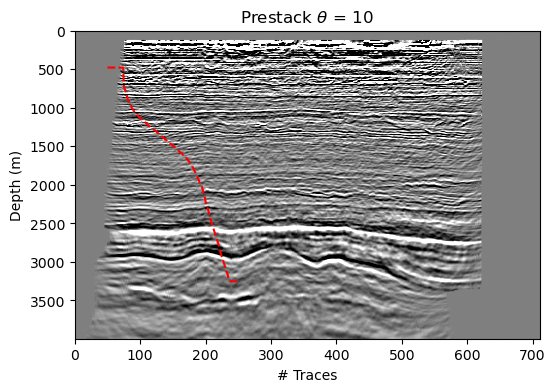

In [6]:
plt.figure(figsize=(6,4))
plt.imshow(seismicd_prestack_fence[:,10,:].T, cmap='gray', vmin=-1, vmax=1,
           extent=[0, seismicd_prestack_fence.shape[0], 
                   z_seismic_prestack_fence[-1], 
                   z_seismic_prestack_fence[0]])
# Plot the well trajectory
plt.plot(np.arange(len(zwell))[50:250], zwell[50:250], '--r')
plt.title('Prestack $\\theta$ = 10')
plt.xlabel('# Traces')
plt.ylabel('Depth (m)')
plt.axis('tight')

Plot the data in offset, angle, and the area of inversion

In [7]:
## Get the window depth for the prestack where the well log has information. 
window_min, window_max, well_start_data, well_end_data = get_depth_window_fence_Volve(well_vp_prestack_sampling=well_vp_prestack_sampling, 
                                                                                      zwell_seismic=zwell_seismic, 
                                                                                      z_seismic_prestack_fence=z_seismic_prestack_fence)

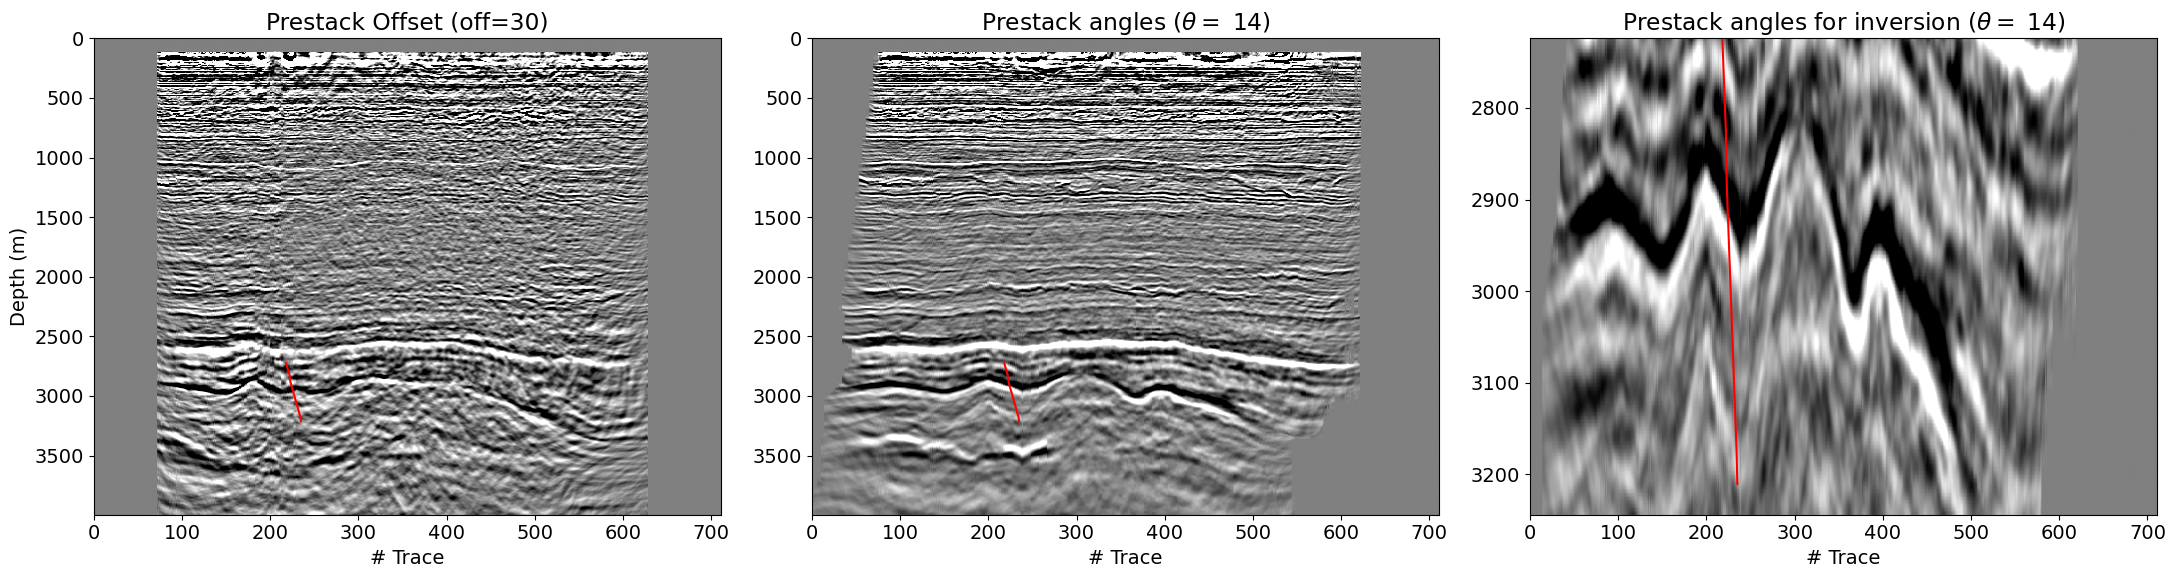

In [8]:
## Plot the data 
fig = plot_Volve_seismic_data(wellname=wellname, offset_num=30, angle=14, 
                            zwell=zwell, z_seismic_prestack_fence=z_seismic_prestack_fence, 
                            window_min=window_min, window_max=window_max, 
                            offset=offset, seismicd_prestack_fence=seismicd_prestack_fence,
                            fontsize=14, title_on=False)

Therefore, the prestack for the inverson is:

In [9]:
d = seismicd_prestack_fence[:,:,window_min:window_max]

In addition, it is necessary to obtain the background models of the fence based on velocity data. These models will serve as our initial guess for the inversion process ($\phi_{bg}$, $\mathrm{Vsh_{bg}}$, and $\mathrm{Sw_{bg}}$). Similarly, the $\mathrm{Vp_{bg}}$, $\mathrm{Vs_{bg}}$, and $\mathrm{\rho_{bg}}$ are needed to create the background AVO synthetic gather $\mathrm{D_b}$

In [10]:
#Smoothing velocity
v_fence_depth = gaussian_filter(v_fence_depth, sigma=60)

# Background models of Elastic parameters 
# Coefficients for the background models
intercept_vp, gradient_vp = -1733.7705987246495, 1.4613508156641841
intercept_vs, gradient_vs = -637.3305563365548, 0.7158182144744273
intercept_rho, gradient_rho = 1.6762212749420877, 0.00020151496167424972


vp_fence_bg = create_background_model(a=gradient_vp, b=intercept_vp, vel = v_fence_depth)
vs_fence_bg = create_background_model(a=gradient_vs, b=intercept_vs, vel = v_fence_depth)
rho_fence_bg = create_background_model(a=gradient_rho, b=intercept_rho, vel =  v_fence_depth)

# ai_fence_bg = vp_fence_bg*rho_fence_bg
# si_fence_bg = vs_fence_bg*rho_fence_bg


# Background models of Petrophysical paramters
# Coefficients for the background models
intercept_phi, gradient_phi = 0.5855599054619403,  -0.00012061601726243674
intercept_vsh, gradient_vsh = 3.2518732973828266, -0.0007709875968411482
intercept_sw, gradient_sw = -0.0758987445846312, 0.0002481488872455055

phi_fence_bg = create_background_model(a=gradient_phi, b=intercept_phi, vel = v_fence_depth)
vsh_fence_bg = create_background_model(a=gradient_vsh, b=intercept_vsh, vel = v_fence_depth)
sw_fence_bg= create_background_model(a=gradient_sw, b=intercept_sw, vel = v_fence_depth)

In [11]:
# fig = plot_background_models_fence(vp_fence_bg=vp_fence_bg, vs_fence_bg=vs_fence_bg, rho_fence_bg=rho_fence_bg, 
#                                  phi_fence_bg=phi_fence_bg, vsh_fence_bg=vsh_fence_bg, sw_fence_bg=sw_fence_bg, 
#                                  seismicd_prestack_fence=seismicd_prestack_fence, z_seismic_prestack_fence=z_seismic_prestack_fence)


Furthermore, it is essential to crop the background models to the same window as the prestack data before performing the inversion. 

In [12]:
## Elastic
vp_fence_bg = vp_fence_bg[:,window_min:window_max]
vs_fence_bg = vs_fence_bg[:,window_min:window_max]
rho_fence_bg = rho_fence_bg[:,window_min:window_max]

## Petrophysical
phi_fence_bg = phi_fence_bg[:,window_min:window_max]
vsh_fence_bg = vsh_fence_bg[:,window_min:window_max]
sw_fence_bg = sw_fence_bg[:,window_min:window_max]

In [13]:
# fig = plot_background_models_fence(vp_fence_bg=vp_fence_bg, vs_fence_bg=vs_fence_bg, rho_fence_bg=rho_fence_bg, 
#                                  phi_fence_bg=phi_fence_bg, vsh_fence_bg=vsh_fence_bg, sw_fence_bg=sw_fence_bg, 
#                                  seismicd_prestack_fence=d, z_seismic_prestack_fence=z_seismic_prestack_fence[window_min:window_max])

### Well log information 

Here, we will present the available well log information, which will be utilized in the subsequent Seis2Rock training process. We first need a bit of cleaning.

In [14]:
#Processing elastic logs
vp, vs, rho, vp_back, vs_back, rho_back = process_well_logs(log_1=well_vp_prestack_sampling, 
                                                            log_2=well_vs_prestack_sampling, 
                                                            log_3=well_rho_prestack_sampling, 
                                                            depth_min=well_start_data, 
                                                            depth_max=well_end_data,
                                                            nsmooth=40)

#If AI and SI logs are needed: 
ai = vp*rho
si = vs*rho

#Processing petrophysical logs
phi, vsh, sw, phi_back, vsh_back, sw_back = process_well_logs(log_1=well_phi_prestack_sampling, 
                                                              log_2=well_vsh_prestack_sampling, 
                                                              log_3=well_sw_prestack_sampling, 
                                                              depth_min=well_start_data, 
                                                              depth_max=well_end_data,
                                                              nsmooth=20)


Plot the well logs available and the prestack data along the well

In [15]:
thetamin=0
thetamax=25
ntheta = 25

# plot_set_logs(well_name='Fence along Well NO_15_9-19_A', 
#               well_prestack=well_prestack, 
#               extent_prestack=(thetamin, thetamax, zwell_seismic[-1], zwell_seismic[0]), 
#               well_depth=zwell_seismic[well_start_data:well_end_data], 
#               vp=vp, 
#               vs=vs, 
#               rho=rho, 
#               phi=phi, 
#               vsh=vsh, 
#               sw=sw,
#               vp_back=vp_back, 
#               vs_back=vs_back, 
#               rho_back=rho_back,
#               phi_back=phi_back, 
#               vsh_back=vsh_back, 
#               sw_back=sw_back, 
#               figsize=(20,14))

Let's process the second well

In [16]:
## Get the window depth for the prestack where the well log has information. 
window_min_2, window_max_2, well_start_data_2, well_end_data_2 = get_depth_window_fence_Volve(well_vp_prestack_sampling=well_vp_prestack_sampling_2, 
                                                                                      zwell_seismic=zwell_seismic_2, 
                                                                                      z_seismic_prestack_fence=z_seismic_prestack_fence_2)

In [17]:
#Processing elastic logs
vp_2, vs_2, rho_2, vp_back_2, vs_back_2, rho_back_2 = process_well_logs(log_1=well_vp_prestack_sampling_2, 
                                                            log_2=well_vs_prestack_sampling_2, 
                                                            log_3=well_rho_prestack_sampling_2, 
                                                            depth_min=well_start_data_2, 
                                                            depth_max=well_end_data_2,
                                                            nsmooth=40)

#If AI and SI logs are needed: 
ai_2 = vp_2*rho_2
si_2 = vs_2*rho_2

#Processing petrophysical logs
phi_2, vsh_2, sw_2, phi_back_2, vsh_back_2, sw_back_2 = process_well_logs(log_1=well_phi_prestack_sampling_2, 
                                                              log_2=well_vsh_prestack_sampling_2, 
                                                              log_3=well_sw_prestack_sampling_2, 
                                                              depth_min=well_start_data_2, 
                                                              depth_max=well_end_data_2,
                                                              nsmooth=40)

In [18]:
thetamin=0
thetamax=25
ntheta = 25

# plot_set_logs(well_name='Fence along Well NO_15_9-19_BT2', 
#               well_prestack=well_prestack_2, 
#               extent_prestack=(thetamin, thetamax, zwell_seismic_2[-1], zwell_seismic_2[0]), 
#               well_depth=zwell_seismic_2[well_start_data_2:well_end_data_2], 
#               vp=vp_2, 
#               vs=vs_2, 
#               rho=rho_2, 
#               phi=phi_2, 
#               vsh=vsh_2, 
#               sw=sw_2,
#               vp_back=vp_back_2, 
#               vs_back=vs_back_2, 
#               rho_back=rho_back_2,
#               phi_back=phi_back_2, 
#               vsh_back=vsh_back_2, 
#               sw_back=sw_back_2, 
#               figsize=(20,14))

### Wavelet estimation

Lastly, we need to acquire the necessary wavelet. This step is crucial for further analysis and processing. Here we use the wavelet scaling obtained in one of the previous notebooks. 

In [19]:
# Statistical Wavelet estimation
nfft = 512
nt_wav = 41
# wav_scaling =18
wav_scaling =12.5

wav_est, t_wav ,fwest, wav_est_fft = get_wavelet_estimate(nt_wav=nt_wav, nfft=nfft, wav_scaling=wav_scaling, 
                                    prestack_data=d, 
                                    dt=dt)


# # Display wavelet
# display_wavelet(wav_est= wav_est, fwest=fwest, wav_est_fft=wav_est_fft, 
#                 t_wav= t_wav, nfft=nfft, fontsize = 14)

## Seis2Rock framework

Now, we come to the most exciting part, where we apply the proposed methodology. We begin with the training phase, and it's important to note that we are not training any neural network in this context. The term "training" refers to obtaining the optimal basis functions $\mathrm{Fp}$ learned from the AVO synthetic gather.

In [20]:
#stacking the Elastic logs 
vp_stack = np.concatenate((vp, vp_2))
vs_stack = np.concatenate((vs, vs_2))
rho_stack = np.concatenate((rho, rho_2))

vp_stack_back= np.concatenate((vp_back, vp_back_2))
vs_stack_back = np.concatenate((vs_back, vs_back_2))
rho_stack_back = np.concatenate((rho_back, rho_back_2))


#stacking the Petrophysical logs 
phi_stack = np.concatenate((phi, phi_2))
vsh_stack = np.concatenate((vsh, vsh_2))
sw_stack = np.concatenate((sw, sw_2))

phi_stack_back = np.concatenate((phi_back, phi_back_2))
vsh_stack_back = np.concatenate((vsh_back, vsh_back_2))
sw_stack_back = np.concatenate((sw_back, sw_back_2))

In [21]:
# Select number of p optimal coeffcients 
p = 2
Fp, Lp, Vp, F, L, V, r_zoeppritz, r_zoeppritz_back, d_well = Seis2Rock_training(vp=vp_stack, vs=vs_stack, rho=rho_stack, 
                                                                      wav_est=wav_est, nt_wav=nt_wav, 
                                                                      vp_back=vp_stack_back, vs_back=vs_stack_back, rho_back=rho_stack_back, 
                                                                      p=p, 
                                                                      thetamin=0, thetamax=25, ntheta=25)

Computing AVO synthetic gathers from the well logs...
Performing SVD...
Extracting Optimal basis functions Fp..
Done! xD
2


Just to double check, let us look at the singular values

### Modifying the background model of Sw to see if we can recover the Sw more appropiately.

To improve the recovery of Sw (water saturation), we will modify the background model of Sw and assess its impact on the results. Here we will repeat the background model of the well along the 2D fence

In [22]:
sw_fence_bg = np.tile(sw_back, (sw_fence_bg.shape[0], 1))

In [23]:
b_optAVO, r_zoeppritz_back, Cp, Hp, Cp_estimated = Seis2Rock_inference(vp=vp_fence_bg, vs=vs_fence_bg, rho=rho_fence_bg, 
                                                         wav_est=wav_est, nt_wav=nt_wav, dtheta=d, 
                                                         Fp=Fp, Lp=Lp, Vp=Vp, 
                                                         phi=phi_stack, vsh=vsh_stack, sw=sw_stack, 
                                                         phi_back=phi_stack_back, vsh_back=vsh_stack_back, sw_back=sw_stack_back, 
                                                         d=d_well,
                                                         thetamin=0, thetamax=25, ntheta=25)

Computing AVO synthetic gather for background models...
Calculating matrix of optimal coefficients Cp...
Creating the new data term (Petrophysical coefficeints B)...
Done xD !


In [24]:
## Here we should create the boptAVO taking into accoun a block diagonal operator per well the previous b is cocatenating all logs and creating an operator from those

#First Well
m_full_1 = np.stack((phi, vsh, sw), axis=0)
m_back_1 = np.stack((phi_back, vsh_back, sw_back), axis=0)

#Second Well
m_full_2 = np.stack((phi_2, vsh_2, sw_2), axis=0)
m_back_2 = np.stack((phi_back_2, vsh_back_2, sw_back_2), axis=0)


Logsize_1 = len(phi)
Logsize_2 = len(phi_2)
kind = 'forward'

# PoststackLinearModelling operator
D_1 = pylops.avo.poststack.PoststackLinearModelling(wav_est, nt0=Logsize_1, spatdims=Logsize_1, explicit=True, kind=kind)
D_A_1 = D_1.A.copy()

D_2 = pylops.avo.poststack.PoststackLinearModelling(wav_est, nt0=Logsize_2, spatdims=Logsize_2, explicit=True, kind=kind)
D_A_2 = D_2.A.copy()


#Combine full operator for two wells
# Create zero matrices for padding
zeros_for_D_A_1 = np.zeros((D_A_1.shape[0], D_A_2.shape[1]))
zeros_for_D_A_2 = np.zeros((D_A_2.shape[0], D_A_1.shape[1]))


# Create a block diagonal matrix
D_A = np.block([[D_A_1, zeros_for_D_A_1],
                [zeros_for_D_A_2, D_A_2]])

m_full = np.concatenate((m_full_1, m_full_2), axis=1)
m_back = np.concatenate((m_back_1, m_back_2), axis=1)

# Compute b_full_prof and b_back_prof
b_full_prof = D_A @ m_full.T
b_back_prof = D_A @ m_back.T

# Calculate the new data term (Petrophysical coefficients B)
b_optAVO = Cp.transpose(0, 2, 1) @ Hp.T @ (b_full_prof - b_back_prof)
b_optAVO = b_optAVO.transpose(2, 1, 0)

## Laplacian Regularization (w/o Bounds)

In [25]:
## Series of poststack seismic inversion (one per parameter)
## Here we use B as our 'new data term' which is the petrophysical coefficients

## Creating Post Stack Operator
kind =  'forward'
D = pylops.avo.poststack.PoststackLinearModelling(wav_est, nt0=b_optAVO.shape[1], 
                                                  spatdims=b_optAVO.shape[2],explicit=True, kind=kind)

## Creating Regularization (In this case Laplacian Regularization)
D2op  = Laplacian([b_optAVO.shape[1],  b_optAVO.shape[2]], dtype='float64', weights=(1,1000))



## Hyperparameters for optimization
niter = 200
lamba1 = 0.1
damp1 = 4


## Inverting for porosity
phi_inv_dense_reg = regularized_inversion(D, b_optAVO[0].ravel(), Regs=[D2op],
                                    epsRs=[lamba1],x0=(phi_fence_bg.T.ravel()),
                                    **dict(iter_lim=niter, damp=damp1))[0].reshape(phi_fence_bg.T.shape) 

## Inverting for vsh
vsh_inv_dense_reg = regularized_inversion(D, b_optAVO[1].ravel(), Regs=[D2op],
                                    epsRs=[lamba1],x0=(vsh_fence_bg.T.ravel()),
                                    **dict(iter_lim=niter, damp=damp1))[0].reshape(vsh_fence_bg.T.shape) 

## Inverting for sw
sw_inv_dense_reg = regularized_inversion(D, b_optAVO[2].ravel(), Regs=[D2op],
                                    epsRs=[lamba1],x0=sw_fence_bg.T.ravel(),
                                    **dict(iter_lim=niter, damp=damp1))[0].reshape(sw_fence_bg.T.shape) 


## Laplacian Regularization (bounded)

In [26]:
# Porosity

kind ='forward'
D = pylops.avo.poststack.PoststackLinearModelling(wav_est, nt0=b_optAVO.shape[1], 
                                                  spatdims=b_optAVO.shape[2],explicit=True, kind=kind)

## Creating Regularization (In this case Laplacian Regularization)
D2op  = Laplacian([b_optAVO.shape[1],  b_optAVO.shape[2]], dtype='float64', weights=(1,1))

# Data and background model
mback_phi = phi_fence_bg.T.ravel()
b_phi = b_optAVO[0].ravel()

#Normalize operator and data term by eigvalues
eigmax = (D.H @ D).eigs(1)
D = np.sqrt(1/eigmax[0].real) * D 
D.dimsd = (D.shape[1], )
b_phi = np.sqrt(1/eigmax[0].real) * b_phi

# Stack the two operators
# eps = np.sqrt(1e1)
eps = 2.5
Op = pylops.VStack([D, eps*D2op])

# Stack the data
data = np.hstack([b_phi, np.zeros(D2op.shape[1])])

# L2 proximal
l2 = L2(Op=Op, b=data, x0=mback_phi, niter=10, warm=True)

# Indicator of box proximal
Bound = Box(lower=0, upper=1)

# Inversion
minv_phi_lap = AcceleratedProximalGradient(l2, Bound, mback_phi, niter=200)
minv_phi_lap = minv_phi_lap.reshape(phi_fence_bg.T.shape)


In [27]:
# Shale content

kind ='forward'
D = pylops.avo.poststack.PoststackLinearModelling(wav_est, nt0=b_optAVO.shape[1], 
                                                  spatdims=b_optAVO.shape[2],explicit=True, kind=kind)

## Creating Regularization (In this case Laplacian Regularization)
D2op  = Laplacian([b_optAVO.shape[1],  b_optAVO.shape[2]], dtype='float64', weights=(1,8))

# Data and background model
mback_vsh = vsh_fence_bg.T.ravel()
b_vsh = b_optAVO[1].ravel()

#Normalize operator and data term by eigvalues
eigmax = (D.H @ D).eigs(1)
D = np.sqrt(1/eigmax[0].real) * D 
D.dimsd = (D.shape[1], )
b_vsh = np.sqrt(1/eigmax[0].real) * b_vsh

# Stack the two operators
eps = np.sqrt(1e-1)
Op = pylops.VStack([D, eps*D2op])

# Stack the data
data = np.hstack([b_vsh, np.zeros(D2op.shape[1])])

# L2 proximal
l2 = L2(Op=Op, b=data, x0=mback_vsh, niter=10, warm=True)

# Indicator of box proximal
Bound = Box(lower=0, upper=1)

# Inversion
minv_vsh_lap = AcceleratedProximalGradient(l2, Bound, mback_vsh, niter=200)
minv_vsh_lap = minv_vsh_lap.reshape(vsh_fence_bg.T.shape)

In [28]:
# Water saturation

kind ='forward'
D = pylops.avo.poststack.PoststackLinearModelling(wav_est, nt0=b_optAVO.shape[1], 
                                                  spatdims=b_optAVO.shape[2],explicit=True, kind=kind)

## Creating Regularization (In this case Laplacian Regularization)
D2op  = Laplacian([b_optAVO.shape[1],  b_optAVO.shape[2]], dtype='float64', weights=(1,1))

# Data and background model
mback_sw = sw_fence_bg.T.ravel()
b_sw = b_optAVO[2].ravel()

#Normalize operator and data term by eigvalues
eigmax = (D.H @ D).eigs(1)
D = np.sqrt(1/eigmax[0].real) * D 
D.dimsd = (D.shape[1], )
b_sw = np.sqrt(1/eigmax[0].real) * b_sw

# Stack the two operators
eps = np.sqrt(1e1)
Op = pylops.VStack([D, eps*D2op])

# Stack the data
data = np.hstack([b_sw, np.zeros(D2op.shape[1])])

# L2 proximal
l2 = L2(Op=Op, b=data, x0=mback_sw, niter=10, warm=True)

# Indicator of box proximal
Bound = Box(lower=0, upper=1)

# Inversion
minv_sw_lap = AcceleratedProximalGradient(l2, Bound, mback_sw, niter=200)
minv_sw_lap = minv_sw_lap.reshape(sw_fence_bg.T.shape)

## TV PD (Bounded)

In [29]:
# Porosity

kind ='forward'
D = pylops.avo.poststack.PoststackLinearModelling(wav_est, nt0=b_optAVO.shape[1], 
                                                  spatdims=b_optAVO.shape[2],explicit=True, kind=kind)

b_phi = b_optAVO[0].ravel()
mback_phi = phi_fence_bg.T.ravel()

eigmax = (D.H @ D).eigs(1)
D = np.sqrt(1/eigmax[0].real) * D 
D.dimsd = (D.shape[1], )

b_phi = np.sqrt(1/eigmax[0].real) * b_phi


# L2 proximal Operator
l2 = L2(Op=D, b=b_phi, x0=mback_phi, niter=20, warm=True)

Dop = Gradient(dims=phi_fence_bg.T.shape, edge=True, dtype=D.dtype, kind='forward')
IOp = Identity(phi_fence_bg.T.size)

Op = pylops.VStack([Dop, IOp])

#TV
sigma = 0.01
l1 = L21(ndim=2, sigma=sigma)

# Indicator of box proximal
Bound = Box(lower=0, upper=1)
lprox = VStack([l1, Bound], nn=[2*phi_fence_bg.T.size, phi_fence_bg.T.size])


L = 9. # np.real((Dop.H*Dop).eigs(neigs=1, which='LM')[0])
# tau = 0.02 / np.sqrt(L)
tau = 1
mu = 0.95 / (tau * L)

minv_phi_tv = PrimalDual(l2, lprox, Op, tau=tau, mu=mu, theta=1., x0=mback_phi.ravel(), niter=100, gfirst=True, show=False)
minv_phi_tv = minv_phi_tv.reshape(phi_fence_bg.T.shape) 


In [30]:
# Shale content

kind ='forward'
D = pylops.avo.poststack.PoststackLinearModelling(wav_est, nt0=b_optAVO.shape[1], 
                                                  spatdims=b_optAVO.shape[2],explicit=True, kind=kind)

b_vsh = b_optAVO[1].ravel()
mback_vsh = vsh_fence_bg.T.ravel()

eigmax = (D.H @ D).eigs(1)
D = np.sqrt(1/eigmax[0].real) * D 
D.dimsd = (D.shape[1], )

b_vsh = np.sqrt(1/eigmax[0].real) * b_vsh


# L2 proximal Operator
l2 = L2(Op=D, b=b_vsh, x0=mback_vsh, niter=20, warm=True)

Dop = Gradient(dims=vsh_fence_bg.T.shape, edge=True, dtype=D.dtype, kind='forward')
IOp = Identity(vsh_fence_bg.T.size)

Op = pylops.VStack([Dop, IOp])

#TV
sigma = 0.08
l1 = L21(ndim=2, sigma=sigma)

# Indicator of box proximal
Bound = Box(lower=0, upper=1)
lprox = VStack([l1, Bound], nn=[2*vsh_fence_bg.T.size, vsh_fence_bg.T.size])


L = 9. # np.real((Dop.H*Dop).eigs(neigs=1, which='LM')[0])
# tau = 0.02 / np.sqrt(L)
tau = 1
mu = 0.95 / (tau * L)

minv_vsh_tv = PrimalDual(l2, lprox, Op, tau=tau, mu=mu, theta=1., x0=mback_vsh.ravel(), niter=100, gfirst=True, show=False)
minv_vsh_tv = minv_vsh_tv.reshape(vsh_fence_bg.T.shape) 


In [31]:
# Water saturation

kind ='forward'
D = pylops.avo.poststack.PoststackLinearModelling(wav_est, nt0=b_optAVO.shape[1], 
                                                  spatdims=b_optAVO.shape[2],explicit=True, kind=kind)

b_sw = b_optAVO[2].ravel()
mback_sw = sw_fence_bg.T.ravel()

eigmax = (D.H @ D).eigs(1)
D = np.sqrt(1/eigmax[0].real) * D 
D.dimsd = (D.shape[1], )

b_sw = np.sqrt(1/eigmax[0].real) * b_sw


# L2 proximal Operator
l2 = L2(Op=D, b=b_sw, x0=mback_sw, niter=20, warm=True)

Dop = Gradient(dims=sw_fence_bg.T.shape, edge=True, dtype=D.dtype, kind='forward')
IOp = Identity(sw_fence_bg.T.size)

Op = pylops.VStack([Dop, IOp])

#TV
sigma = 0.02
l1 = L21(ndim=2, sigma=sigma)

# Indicator of box proximal
Bound = Box(lower=0, upper=1)
lprox = VStack([l1, Bound], nn=[2*sw_fence_bg.T.size, sw_fence_bg.T.size])


L = 9. # np.real((Dop.H*Dop).eigs(neigs=1, which='LM')[0])
# tau = 0.02 / np.sqrt(L)
tau = 1
mu = 0.95 / (tau * L)

minv_sw_tv = PrimalDual(l2, lprox, Op, tau=tau, mu=mu, theta=1., x0=mback_sw.ravel(), niter=100, gfirst=True, show=False)
minv_sw_tv = minv_sw_tv.reshape(sw_fence_bg.T.shape) 


## PnP PD (Bounded)

In [32]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Pre-trained DRUNet
model_02 = UNetRes(in_nc=2)
model_02.load_state_dict(torch.load('../../denoisers/drunet_gray.pth'))
model_02.eval().to(device);

In [33]:
# PnP porosity

# opertator
kind ='forward'
D = pylops.avo.poststack.PoststackLinearModelling(wav_est, nt0=b_optAVO.shape[1], 
                                                  spatdims=b_optAVO.shape[2],explicit=True, kind=kind)

mback_phi = phi_fence_bg.T.ravel()
b_phi = b_optAVO[0].ravel()


# scaling by eigenvalues
eigmax = (D.H @ D).eigs(1)
D = np.sqrt(1/eigmax[0].real) * D 
D.dimsd = (D.shape[1], )
b_phi = np.sqrt(1/eigmax[0].real) * b_phi


# L2 proximal Operator
l2 = L2(Op=D, b=b_phi, x0=mback_phi, niter=20, warm=True)

Iop = Identity(phi_fence_bg.T.size)
Op = pylops.VStack([Iop, Iop])


L_pnp = 2.
tau_pnp = 1
sigma_pnp = .001
mu_pnp = 1. / (tau_pnp * L_pnp)

niter_pnp = 200


denoiser_dn = lambda x, mu_: scaling_DRUNET(model_02, torch.from_numpy(x).float(), mu_, sigma_pnp)
ddenoiser = _Denoise(denoiser_dn, dims=phi_fence_bg.T.shape)

Bound = Box(lower=0, upper=1)
lprox = VStack([ddenoiser, Bound], nn=[phi_fence_bg.T.size, phi_fence_bg.T.size])


# Invert
minv_phi_pnp = PrimalDual(l2, lprox, Op, x0=mback_phi, tau=tau_pnp, mu=mu_pnp, gfirst=True,
                              niter=niter_pnp, show=False)

minv_phi_pnp = minv_phi_pnp.reshape(phi_fence_bg.T.shape)



In [34]:
# PnP vsh

# opertator
kind ='forward'
D = pylops.avo.poststack.PoststackLinearModelling(wav_est, nt0=b_optAVO.shape[1], 
                                                  spatdims=b_optAVO.shape[2],explicit=True, kind=kind)

mback_vsh = vsh_fence_bg.T.ravel()
b_vsh = b_optAVO[1].ravel()


# scaling by eigenvalues
eigmax = (D.H @ D).eigs(1)
D = np.sqrt(1/eigmax[0].real) * D 
D.dimsd = (D.shape[1], )
b_vsh = np.sqrt(1/eigmax[0].real) * b_vsh


# L2 proximal Operator
l2 = L2(Op=D, b=b_vsh, x0=mback_vsh, niter=20, warm=True)

Iop = Identity(vsh_fence_bg.T.size)
Op = pylops.VStack([Iop, Iop])


L_pnp = 2.
tau_pnp = 1
sigma_pnp = .001
mu_pnp = 1. / (tau_pnp * L_pnp)

niter_pnp = 200


denoiser_dn = lambda x, mu_: scaling_DRUNET(model_02, torch.from_numpy(x).float(), mu_, sigma_pnp)
ddenoiser = _Denoise(denoiser_dn, dims=phi_fence_bg.T.shape)

Bound = Box(lower=0, upper=1)
lprox = VStack([ddenoiser, Bound], nn=[vsh_fence_bg.T.size, vsh_fence_bg.T.size])


# Invert
minv_vsh_pnp = PrimalDual(l2, lprox, Op, x0=mback_vsh, tau=tau_pnp, mu=mu_pnp, gfirst=True,
                              niter=niter_pnp, show=False)

minv_vsh_pnp = minv_vsh_pnp.reshape(vsh_fence_bg.T.shape)



In [35]:
# PnP sw

# opertator
kind ='forward'
D = pylops.avo.poststack.PoststackLinearModelling(wav_est, nt0=b_optAVO.shape[1], 
                                                  spatdims=b_optAVO.shape[2],explicit=True, kind=kind)

mback_sw = sw_fence_bg.T.ravel()
b_sw = b_optAVO[2].ravel()


# scaling by eigenvalues
eigmax = (D.H @ D).eigs(1)
D = np.sqrt(1/eigmax[0].real) * D 
D.dimsd = (D.shape[1], )
b_sw = np.sqrt(1/eigmax[0].real) * b_sw


# L2 proximal Operator
l2 = L2(Op=D, b=b_sw, x0=mback_sw, niter=20, warm=True)

Iop = Identity(sw_fence_bg.T.size)
Op = pylops.VStack([Iop, Iop])


L_pnp = 2.
tau_pnp = 1
sigma_pnp = .002
mu_pnp = 1. / (tau_pnp * L_pnp)

niter_pnp = 100


denoiser_dn = lambda x, mu_: scaling_DRUNET(model_02, torch.from_numpy(x).float(), mu_, sigma_pnp)
ddenoiser = _Denoise(denoiser_dn, dims=sw_fence_bg.T.shape)

Bound = Box(lower=0, upper=1)
lprox = VStack([ddenoiser, Bound], nn=[sw_fence_bg.T.size, sw_fence_bg.T.size])


# Invert
minv_sw_pnp = PrimalDual(l2, lprox, Op, x0=mback_sw, tau=tau_pnp, mu=mu_pnp, gfirst=True,
                              niter=niter_pnp, show=False)

minv_sw_pnp = minv_sw_pnp.reshape(sw_fence_bg.T.shape)



## Comparison 

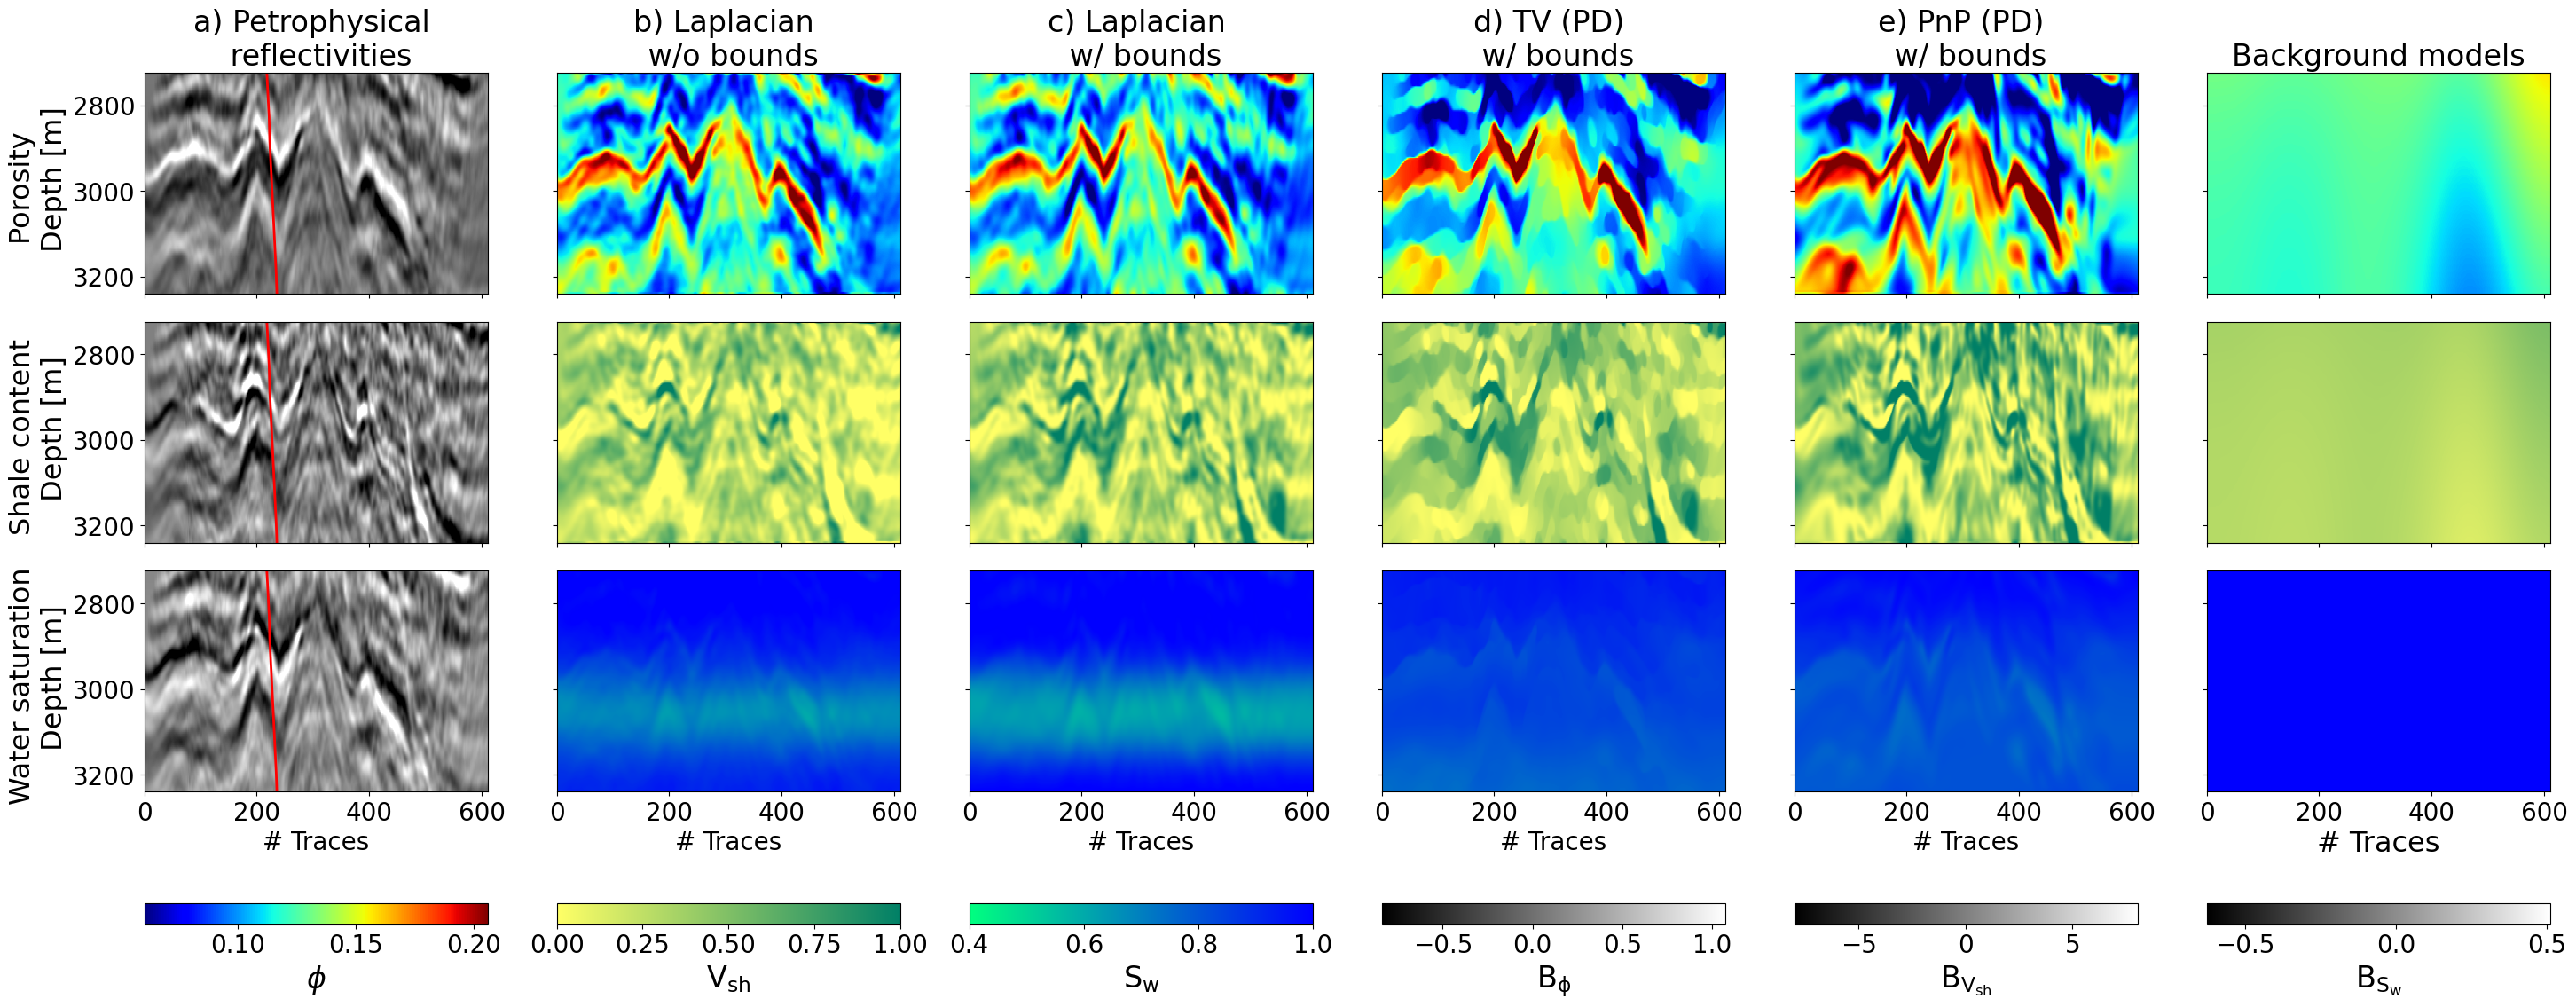

In [43]:
fig = plot_comparison_Reg_fence(wellname=wellname, prestack_fence=d, zwell=zwell, 
                         z_seismic_prestack_fence=z_seismic_prestack_fence[window_min:window_max], b_optAVO=b_optAVO,
                         phi_inv_dense_reg=phi_inv_dense_reg, vsh_inv_dense_reg=vsh_inv_dense_reg, sw_inv_dense_reg=sw_inv_dense_reg, 
                         minv_phi_lap=minv_phi_lap, minv_vsh_lap=minv_vsh_lap, minv_sw_lap=minv_sw_lap, 
                         minv_phi_tv=minv_phi_tv, minv_vsh_tv=minv_vsh_tv, minv_sw_tv=minv_sw_tv, 
                         minv_phi_pnp=minv_phi_pnp, minv_vsh_pnp=minv_vsh_pnp, minv_sw_pnp=minv_sw_pnp,
                         phi_fence_bg=phi_fence_bg, vsh_fence_bg=vsh_fence_bg, sw_fence_bg=sw_fence_bg, fontsize=20, title_on=False)

# fig.savefig('../../figures_results/comparison_reg_fence_well_19A.png', format='png', dpi=300)


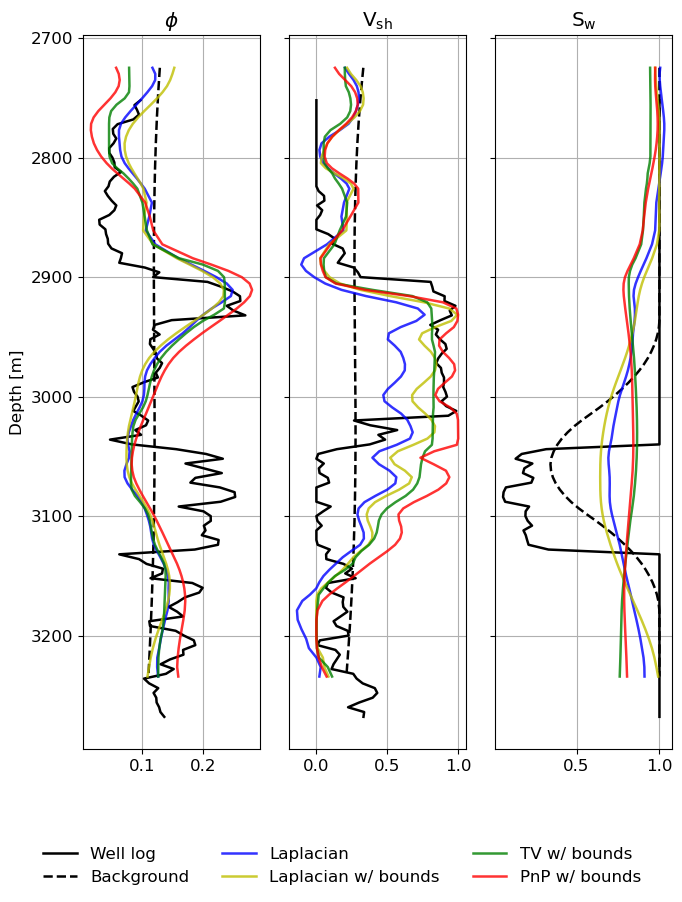

In [41]:
fig = plot_well_results_from_fence_Regularization(wellname=wellname, zwell_seismic=zwell_seismic,
                                   seismicd_prestack_fence=d, zwell=zwell,
                                   z_seismic_prestack_fence=z_seismic_prestack_fence[window_min:window_max],
                                   phi=phi, vsh=vsh, sw=sw,
                                   well_start_data=well_start_data, well_end_data=well_end_data, 
                                   phi_inv_dense_reg=phi_inv_dense_reg, 
                                   vsh_inv_dense_reg=vsh_inv_dense_reg,
                                   sw_inv_dense_reg= sw_inv_dense_reg,
                                   minv_phi_lap=minv_phi_lap, minv_vsh_lap=minv_vsh_lap, minv_sw_lap=minv_sw_lap, 
                                   minv_phi_tv=minv_phi_tv, minv_vsh_tv=minv_vsh_tv, minv_sw_tv=minv_sw_tv, 
                                   minv_phi_pnp=minv_phi_pnp, minv_vsh_pnp=minv_vsh_pnp, minv_sw_pnp=minv_sw_pnp,
                                   phi_fence_bg=phi_fence_bg, 
                                   vsh_fence_bg=vsh_fence_bg, 
                                   sw_fence_bg=sw_fence_bg,
                                   shift=28, fontsize=12, title_on=False)

# fig.savefig('../../figures_results/well_log_comparison_reg_fence_well_19A.png', format='png', dpi=300)